In [1]:
import numpy as np
import pandas as pd
import sys

path='/home/jbohn/jupyter/personal/Kernel_Learning/'
sys.path.append(path)

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from Data.clean_data import clean_quotes

from Features.feature_preprocessing import generate_features_from_quotes

from LOB_Analysis.batch_data import batch_solve_mkl, batch_features
from LOB_Analysis.batch_kernel import train_svm_batch, predict_svm_batch
from LOB_Analysis.iterate_daily_batch import daily_batch



### Fetch Raw Quote Data

- Quotes for AAPL across  NASDAQ : Exchange N 
- Data corresponds to Jan 2020

### Clean & Preprocessing

- Drops market quotes outside of open hours
- Criteria for invalid quotes (inverted spread, zero price or volume)
- Standardizes Participant Timestamp as time index

In [2]:
cleaned_quotes=pd.read_csv(path+'Data/cleaned_AAPL_quotes_2020-01-02.csv',index_col=0)
cleaned_quotes

,Participant_Timestamp,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,...,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:03.296828,140,2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,288805,...,Q,296.19,2.0,Z,296.26,2.0,A,,2,2020-01-02
2020-01-02 09:30:05.489204,141,2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,296557,...,N,296.14,4.0,Z,296.19,4.0,A,,2,2020-01-02
2020-01-02 09:30:05.663684,142,2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,297100,...,Q,296.13,1.0,Z,296.16,2.0,A,,2,2020-01-02
2020-01-02 09:30:06.278858,143,2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,299138,...,Q,296.03,1.0,Z,296.07,4.0,A,,2,2020-01-02
2020-01-02 09:30:14.710996,144,2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,318631,...,Z,295.65,6.0,N,295.74,1.0,A,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175398,87570,2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,30603857,...,Z,300.41,3.0,Q,300.44,4.0,A,,2,2020-01-02
2020-01-02 15:59:46.113982,87571,2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,30643992,...,Z,300.44,2.0,P,300.46,2.0,A,,2,2020-01-02
2020-01-02 15:59:50.118942,87572,2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,30672299,...,Q,300.37,3.0,Q,300.40,4.0,A,,2,2020-01-02
2020-01-02 15:59:52.913707,87573,2020-01-02 15:59:52.914082,N,AAPL,300.29,3.0,300.66,1.0,R,30696052,...,Q,300.36,1.0,Q,300.39,2.0,A,,2,2020-01-02


### Feature Generation

- Generates set of features off quote data 
- Performs time aggregation to 5 second 
- Labels outcome; price direction relative to next interval

In [3]:
### paul : more features in generate_features_from_quotes

In [4]:
labelled_data=generate_features_from_quotes(cleaned_quotes,time_agg=5)
labelled_data

,Exchange,Symbol,Best_Bid_Price,FB0,Best_Offer_Price,FA0,FB2,FA2,p_time,Next_Best_Bid,Next_Best_Offer,outcome
last_interval,,,,,,,,,,,,
2020-01-02 09:30:05,N,AAPL,296.14,4.0,296.19,4.0,2.0,2.0,2020-01-02 09:30:05.489204,295.65,295.74,-1
2020-01-02 09:30:10,N,AAPL,295.65,6.0,295.74,1.0,5.0,-3.0,2020-01-02 09:30:14.710996,295.52,295.63,-1
2020-01-02 09:30:15,N,AAPL,295.52,3.0,295.63,1.0,2.0,0.0,2020-01-02 09:30:17.317319,295.54,295.68,0
2020-01-02 09:30:25,N,AAPL,295.54,2.0,295.68,1.0,-1.0,0.0,2020-01-02 09:30:28.784184,295.67,295.79,0
2020-01-02 09:30:30,N,AAPL,295.67,2.0,295.79,1.0,0.0,0.0,2020-01-02 09:30:34.896431,295.71,295.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:25,N,AAPL,300.43,13.0,300.44,1.0,10.0,0.0,2020-01-02 15:59:25.680175,300.41,300.44,0
2020-01-02 15:59:40,N,AAPL,300.41,3.0,300.44,4.0,-1.0,3.0,2020-01-02 15:59:41.175398,300.44,300.46,0
2020-01-02 15:59:45,N,AAPL,300.44,2.0,300.46,2.0,-1.0,-2.0,2020-01-02 15:59:46.113982,300.37,300.40,-1


### Analysis for Jan 2, 2020

In [5]:
labelled_data=pd.read_csv(path+'Features/Cleaned_Features/labeled_data_2020-01-02.csv',index_col=0)


In [6]:
features=labelled_data[['FB0','FA0','FB2','FA2']]
outcomes=labelled_data['outcome']

features

,FB0,FA0,FB2,FA2
last_interval,,,,
2020-01-02 09:30:05,4.0,4.0,2.0,2.0
2020-01-02 09:30:06,1.0,4.0,0.0,2.0
2020-01-02 09:30:14,6.0,1.0,5.0,-3.0
2020-01-02 09:30:17,3.0,1.0,2.0,0.0
2020-01-02 09:30:28,2.0,1.0,-1.0,0.0
...,...,...,...,...
2020-01-02 15:59:41,3.0,4.0,-1.0,3.0
2020-01-02 15:59:46,2.0,2.0,-1.0,-2.0
2020-01-02 15:59:50,3.0,4.0,1.0,2.0


### Batch Features

- For computational feasiblity will retrain model off batched data looking to evaluate performance in subsequent interval
- Batches features and outcomes in size batch_size which model will be trained from

In [7]:
batch_size=300

batch_data=batch_features(features,outcomes,batch_size)
batch_data

{0.0: {'last_interval': '2020-01-02 09:30:05',
  'features':                      FB0  FA0  FB2   FA2
  last_interval                           
  2020-01-02 09:30:05  4.0  4.0  2.0   2.0
  2020-01-02 09:30:06  1.0  4.0  0.0   2.0
  2020-01-02 09:30:14  6.0  1.0  5.0  -3.0
  2020-01-02 09:30:17  3.0  1.0  2.0   0.0
  2020-01-02 09:30:28  2.0  1.0 -1.0   0.0
  ...                  ...  ...  ...   ...
  2020-01-02 09:36:30  4.0  8.0  3.0 -13.0
  2020-01-02 09:36:31  2.0  4.0  0.0   2.0
  2020-01-02 09:36:32  2.0  2.0  0.0   1.0
  2020-01-02 09:36:33  1.0  4.0 -6.0  -1.0
  2020-01-02 09:36:34  3.0  1.0  1.0   0.0
  
  [300 rows x 4 columns],
  'outcomes': last_interval
  2020-01-02 09:30:05   -1
  2020-01-02 09:30:06   -1
  2020-01-02 09:30:14   -1
  2020-01-02 09:30:17    0
  2020-01-02 09:30:28    0
                        ..
  2020-01-02 09:36:30    0
  2020-01-02 09:36:31    0
  2020-01-02 09:36:32   -1
  2020-01-02 09:36:33    0
  2020-01-02 09:36:34    1
  Name: outcome, Length: 300

### Train Single Kernel across batched dataset

In [8]:
#### Jarryd : single kernel training functionality in Kernels/single_kernel.py

### MKL Training across batched data 


In [9]:
batched_estimates=batch_solve_mkl(features,outcomes,5,batch_size,'gaussian',5,verbose=False)

Batch  0 Last Interval 2020-01-02 09:30:05 complete with weights  [0.         0.20949707 0.23442258 0.26343602 0.29264433]
Batch  300 Last Interval 2020-01-02 09:36:35 complete with weights  [0.19202175 0.20071676 0.20225626 0.20252167 0.20248356]
Batch  600 Last Interval 2020-01-02 09:43:00 complete with weights  [0.         0.24182252 0.2513387  0.25310196 0.25373683]
Batch  900 Last Interval 2020-01-02 09:49:49 complete with weights  [0.19214868 0.19747216 0.2012086  0.20372638 0.20544418]
Batch  1200 Last Interval 2020-01-02 09:56:28 complete with weights  [0.         0.25989127 0.25393451 0.2459001  0.24027412]
Batch  1500 Last Interval 2020-01-02 10:02:52 complete with weights  [0.         0.22418197 0.24206034 0.25946632 0.27429137]
Batch  1800 Last Interval 2020-01-02 10:09:21 complete with weights  [0.46208419 0.20803137 0.13752483 0.10513084 0.08722878]
Batch  2100 Last Interval 2020-01-02 10:15:28 complete with weights  [0.41407409 0.23080519 0.1604098  0.1125101  0.08220082

In [10]:
batch_svm,batch_index=train_svm_batch(batch_data,batched_estimates,'gaussian',5)

In [11]:
evaluation_dict=predict_svm_batch(batch_svm,batch_index,batch_data,batched_estimates,'gaussian',5)

In [12]:
evaluation_dict

{'2020-01-02 09:30:05': {'accuracy': 0.43333333333333335,
  'recall': 0.43333333333333335},
 '2020-01-02 09:36:35': {'accuracy': 0.7533333333333333,
  'recall': 0.7533333333333333},
 '2020-01-02 09:43:00': {'accuracy': 0.54, 'recall': 0.54},
 '2020-01-02 09:49:49': {'accuracy': 0.57, 'recall': 0.57},
 '2020-01-02 09:56:28': {'accuracy': 0.42, 'recall': 0.42},
 '2020-01-02 10:02:52': {'accuracy': 0.5666666666666667,
  'recall': 0.5666666666666667},
 '2020-01-02 10:09:21': {'accuracy': 0.56, 'recall': 0.56},
 '2020-01-02 10:15:28': {'accuracy': 0.5266666666666666,
  'recall': 0.5266666666666666},
 '2020-01-02 10:21:48': {'accuracy': 0.62, 'recall': 0.62},
 '2020-01-02 10:27:44': {'accuracy': 0.5433333333333333,
  'recall': 0.5433333333333333},
 '2020-01-02 10:33:39': {'accuracy': 0.6033333333333334,
  'recall': 0.6033333333333334},
 '2020-01-02 10:40:26': {'accuracy': 0.6866666666666666,
  'recall': 0.6866666666666666},
 '2020-01-02 10:47:42': {'accuracy': 0.7133333333333334,
  'recall':

In [13]:
dts=pd.to_datetime([i for i in evaluation_dict.keys()])
accuracy=np.array([i['accuracy'] for i in evaluation_dict.values()])
recall=np.array([i['recall'] for i in evaluation_dict.values()])

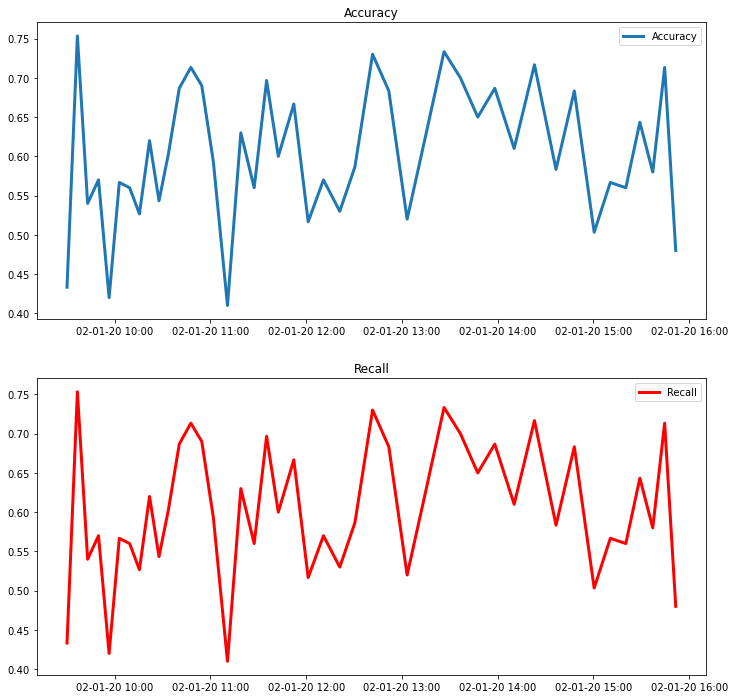

In [14]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(dts,accuracy,lw=3,label='Accuracy')
axis[0].set_title('Accuracy')
axis[1].plot(dts,recall,lw=3,label='Recall',color='red')
axis[1].set_title('Recall')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

### Analysis across Jan 3, 2020

In [15]:
labelled_data=pd.read_csv(path+'Features/Cleaned_Features/labeled_data_2020-01-03.csv',index_col=0)

In [16]:
features=labelled_data[['FB0','FA0','FB2','FA2']]
outcomes=labelled_data['outcome']

features

,FB0,FA0,FB2,FA2
last_interval,,,,
2020-01-03 09:30:01,1.0,1.0,-1.0,0.0
2020-01-03 09:30:02,1.0,1.0,0.0,-1.0
2020-01-03 09:30:03,5.0,1.0,4.0,0.0
2020-01-03 09:30:04,1.0,2.0,-4.0,1.0
2020-01-03 09:30:07,2.0,2.0,1.0,1.0
...,...,...,...,...
2020-01-03 15:59:40,1.0,137.0,0.0,136.0
2020-01-03 15:59:47,1.0,2.0,0.0,-2.0
2020-01-03 15:59:53,3.0,1.0,2.0,-1.0


In [17]:
batch_size=300

batch_data=batch_features(features,outcomes,batch_size)
batch_data

{0.0: {'last_interval': '2020-01-03 09:30:01',
  'features':                      FB0  FA0  FB2  FA2
  last_interval                          
  2020-01-03 09:30:01  1.0  1.0 -1.0  0.0
  2020-01-03 09:30:02  1.0  1.0  0.0 -1.0
  2020-01-03 09:30:03  5.0  1.0  4.0  0.0
  2020-01-03 09:30:04  1.0  2.0 -4.0  1.0
  2020-01-03 09:30:07  2.0  2.0  1.0  1.0
  ...                  ...  ...  ...  ...
  2020-01-03 09:36:02  1.0  1.0 -1.0 -1.0
  2020-01-03 09:36:03  2.0  2.0  0.0  1.0
  2020-01-03 09:36:04  2.0  1.0  0.0 -3.0
  2020-01-03 09:36:06  2.0  1.0  0.0  0.0
  2020-01-03 09:36:08  2.0  4.0 -2.0  2.0
  
  [300 rows x 4 columns],
  'outcomes': last_interval
  2020-01-03 09:30:01   -1
  2020-01-03 09:30:02    0
  2020-01-03 09:30:03    0
  2020-01-03 09:30:04    0
  2020-01-03 09:30:07    0
                        ..
  2020-01-03 09:36:02    0
  2020-01-03 09:36:03   -1
  2020-01-03 09:36:04    0
  2020-01-03 09:36:06    0
  2020-01-03 09:36:08    0
  Name: outcome, Length: 300, dtype: int6

In [18]:
batched_estimates=batch_solve_mkl(features,outcomes,5,batch_size,'gaussian',5,verbose=False)

Batch  0 Last Interval 2020-01-03 09:30:01 complete with weights  [0.         0.21608053 0.23891205 0.26156335 0.28344408]
Batch  300 Last Interval 2020-01-03 09:36:09 complete with weights  [0.         0.24029421 0.24875367 0.25382659 0.25712553]
Batch  600 Last Interval 2020-01-03 09:42:49 complete with weights  [0.         0.22601891 0.24231977 0.25876178 0.27289955]
Batch  900 Last Interval 2020-01-03 09:48:55 complete with weights  [0.40993894 0.24247585 0.15926532 0.11018357 0.07813632]
Batch  1200 Last Interval 2020-01-03 09:55:24 complete with weights  [0.         0.30338217 0.2738045  0.22994764 0.1928657 ]
Batch  1500 Last Interval 2020-01-03 10:02:17 complete with weights  [0.40268055 0.23662699 0.1615422  0.11881659 0.08033367]
Batch  1800 Last Interval 2020-01-03 10:08:06 complete with weights  [0.         0.23077551 0.24614169 0.25691949 0.2661633 ]
Batch  2100 Last Interval 2020-01-03 10:14:00 complete with weights  [0.         0.22960348 0.24849068 0.25858886 0.26331698

In [19]:
batch_svm,batch_index=train_svm_batch(batch_data,batched_estimates,'gaussian',5)

In [20]:
evaluation_dict=predict_svm_batch(batch_svm,batch_index,batch_data,batched_estimates,'gaussian',5)

In [21]:
evaluation_dict

{'2020-01-03 09:30:01': {'accuracy': 0.35333333333333333,
  'recall': 0.35333333333333333},
 '2020-01-03 09:36:09': {'accuracy': 0.7333333333333333,
  'recall': 0.7333333333333333},
 '2020-01-03 09:42:49': {'accuracy': 0.4866666666666667,
  'recall': 0.4866666666666667},
 '2020-01-03 09:48:55': {'accuracy': 0.3233333333333333,
  'recall': 0.3233333333333333},
 '2020-01-03 09:55:24': {'accuracy': 0.32666666666666666,
  'recall': 0.32666666666666666},
 '2020-01-03 10:02:17': {'accuracy': 0.6133333333333333,
  'recall': 0.6133333333333333},
 '2020-01-03 10:08:06': {'accuracy': 0.5166666666666667,
  'recall': 0.5166666666666667},
 '2020-01-03 10:14:00': {'accuracy': 0.39, 'recall': 0.39},
 '2020-01-03 10:20:16': {'accuracy': 0.6533333333333333,
  'recall': 0.6533333333333333},
 '2020-01-03 10:26:15': {'accuracy': 0.4266666666666667,
  'recall': 0.4266666666666667},
 '2020-01-03 10:32:52': {'accuracy': 0.4066666666666667,
  'recall': 0.4066666666666667},
 '2020-01-03 10:39:29': {'accuracy':

In [22]:
dts=pd.to_datetime([i for i in evaluation_dict.keys()])
accuracy=np.array([i['accuracy'] for i in evaluation_dict.values()])
recall=np.array([i['recall'] for i in evaluation_dict.values()])

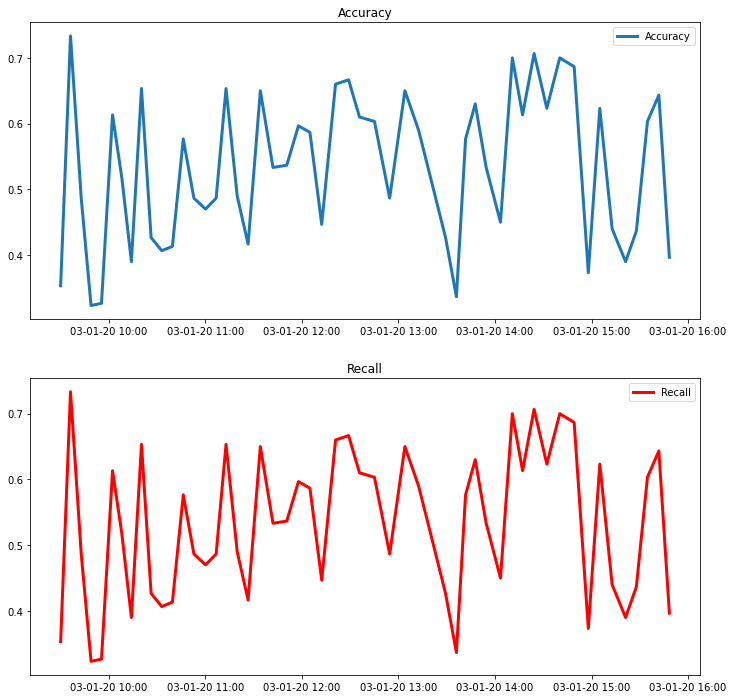

In [23]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(dts,accuracy,lw=3,label='Accuracy')
axis[0].set_title('Accuracy')
axis[1].plot(dts,recall,lw=3,label='Recall',color='red')
axis[1].set_title('Recall')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

### Analysis across all of January 2020

In [24]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=5
time_agg=5
batch_size=300


all_accuracy,all_recall=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:05 complete with weights  [0.         0.20949707 0.23442258 0.26343602 0.29264433]
Batch  300 Last Interval 2020-01-02 09:36:35 complete with weights  [0.         0.2423359  0.25156962 0.25316152 0.25293297]
Batch  600 Last Interval 2020-01-02 09:43:00 complete with weights  [0.         0.24182252 0.2513387  0.25310196 0.25373683]
Batch  900 Last Interval 2020-01-02 09:49:49 complete with weights  [0.19214868 0.19747216 0.2012086  0.20372638 0.20544418]
Batch  1200 Last Interval 2020-01-02 09:56:28 complete with weights  [0.         0.25989127 0.25393451 0.2459001  0.24027412]
Batch  1500 Last Interval 2020-01-02 10:02:52 complete with weights  [0.         0.22418197 0.24206034 0.25946632 0.27429137]
Batch  1800 Last Interval 2020-01-02 10:09:21 complete with weights  [0.46208419

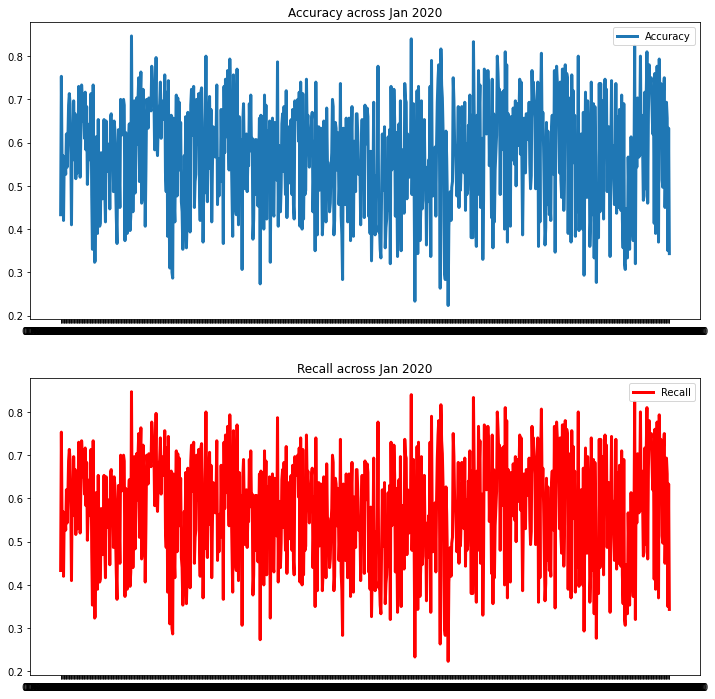

In [25]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(list(all_accuracy.keys()),list(all_accuracy.values()),lw=3,label='Accuracy')
axis[0].set_title('Accuracy across Jan 2020')
axis[1].plot(list(all_recall.keys()),list(all_recall.values()),lw=3,label='Recall',color='red')
axis[1].set_title('Recall across Jan 2020')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)

In [26]:
accuracy_df=pd.DataFrame.from_dict(all_accuracy,orient='index')
accuracy_df.describe()

,0
count,843.000000
mean,0.571068
std,0.125098
min,0.223333
25%,0.476667
50%,0.583333
75%,0.670000
max,0.846667


In [27]:
recall_df=pd.DataFrame.from_dict(all_recall,orient='index')
recall_df.describe()


,0
count,843.000000
mean,0.571068
std,0.125098
min,0.223333
25%,0.476667
50%,0.583333
75%,0.670000
max,0.846667
